## Initialization

## Introduction

For this computer vision project we will be working with a simple data set to predict customer age for use in alcohol sales. 

The project serves as a baseline for future projects surrounding computer vision and can be expanded and optimized given more computational resources (GPU processing). Note that model training was done virtually.

## Objectives

- Train a model that predicts customer age based on photos (faces) for use in alcohol sales
- Measure accuracy (MAE) and determine the usability of the model in real-life scenarios

## Image and Age Data

The dataset is stored in the `/datasets/faces/` folder, we can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Note:

- The number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. 

The label file can be loaded as an usual CSV file.

In [1]:
# Import data manipulation and data visualization libraries

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
df_labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df_labels.shape

(7591, 2)

In [4]:
df_labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Note: Confirmed that the data shows only two columns for the photo and the age of the person

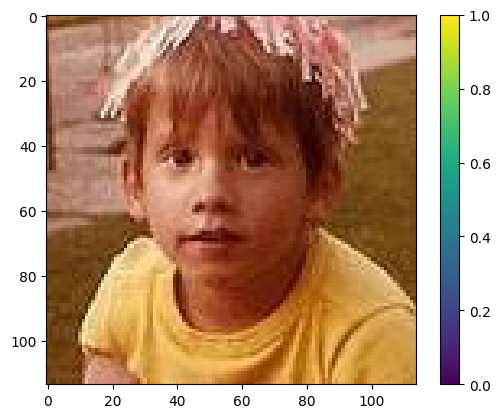

In [5]:
# Test printing first image

image = Image.open('/datasets/faces/final_files/000000.jpg')
array = np.array(image)

array = array/255

plt.imshow(array)
plt.colorbar()

Libraries were loaded correctly.

In [6]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
av_age = df_labels.mean()
print(av_age)

real_age    31.201159
dtype: float64


Note: The average age in the data set is 31 years.

## Exploratory Data Analysis (EDA)

In [9]:
import seaborn as sns

# Create

def plot_statistics(data, column):
    plt.figure(figsize=(18, 6))

    # Distribution Plot
    plt.subplot(1, 3, 3)
    sns.kdeplot(data[column], shade=True)
    plt.title('Age Distribution')

    plt.tight_layout()
    plt.show()



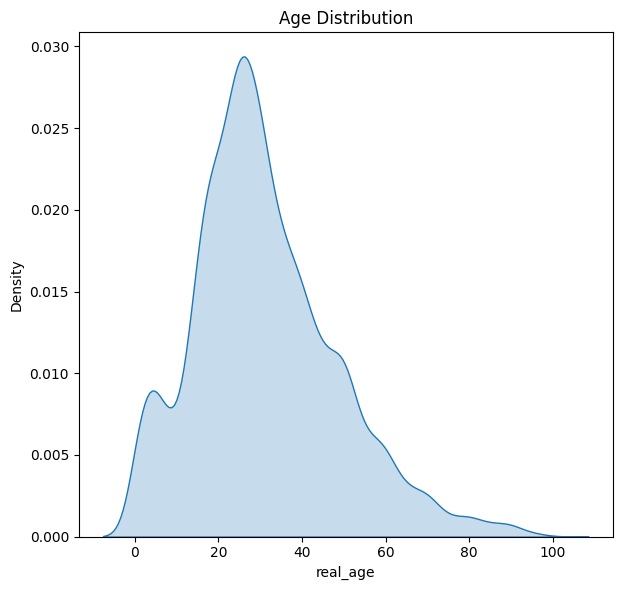

In [10]:
data = df_labels

df = pd.DataFrame(data)

# Generate plots for the 'real_age' column
plot_statistics(df, 'real_age')

Note: The age of the data set skews towards younger individuals.

In [11]:
# Print the first 10 images

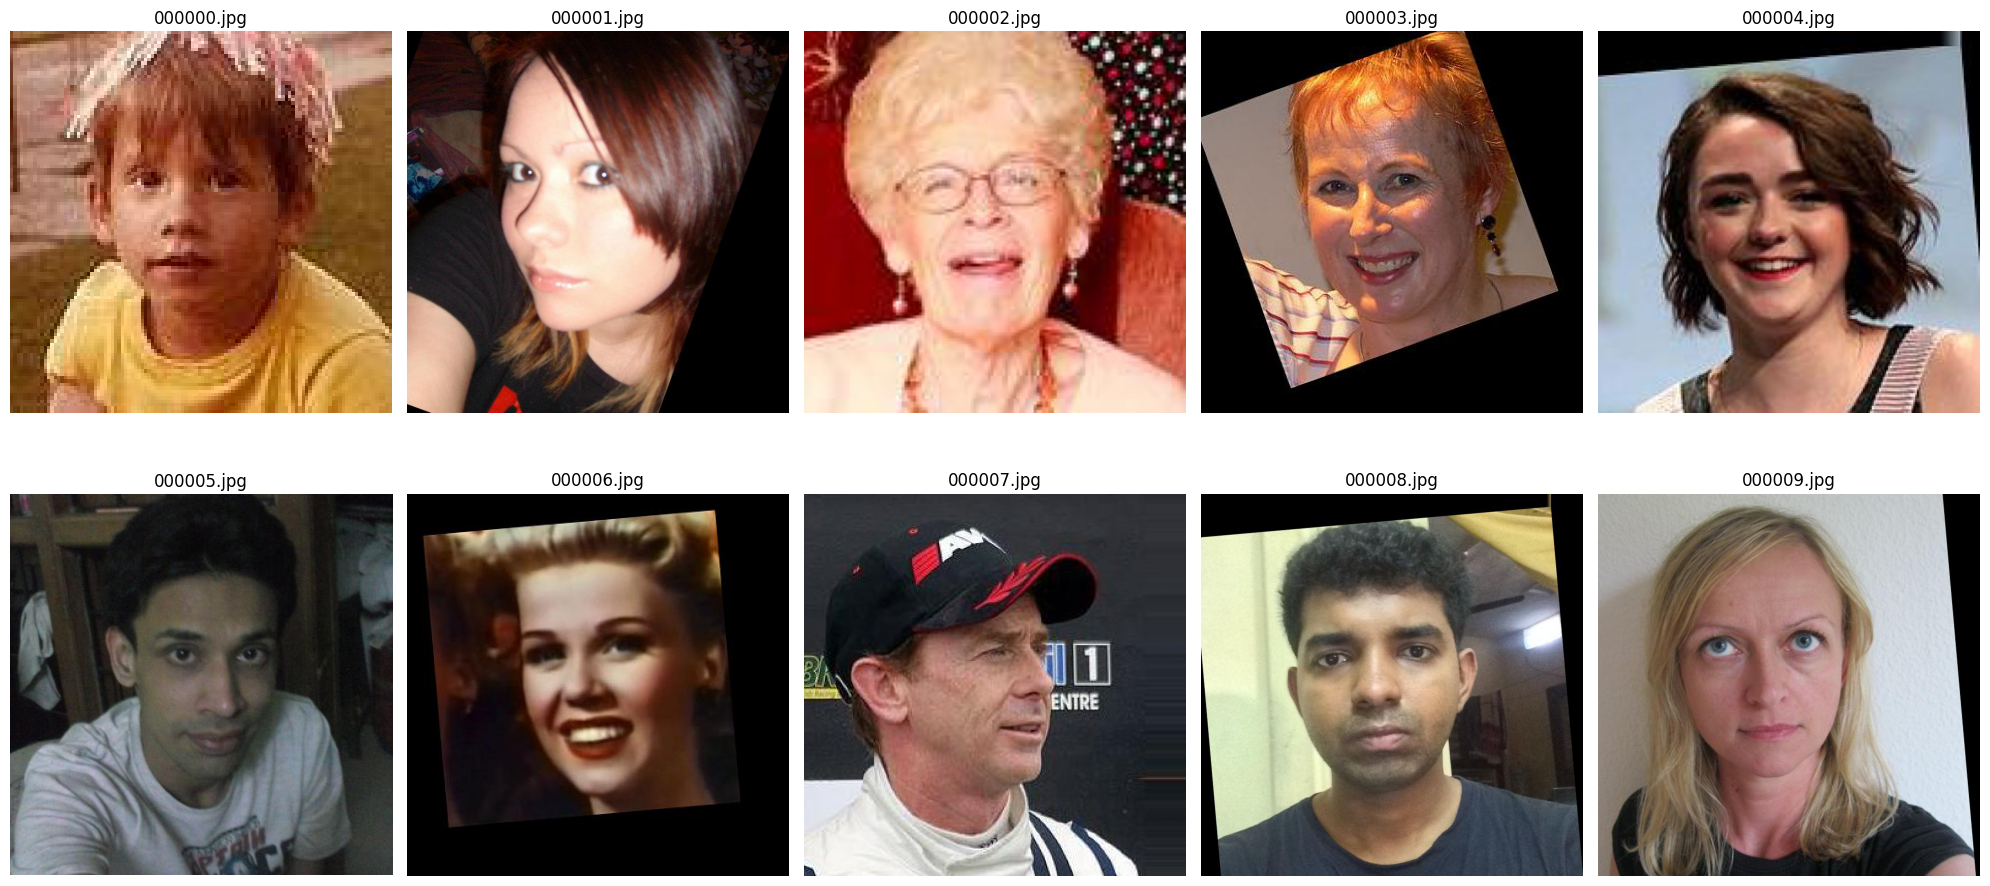

In [12]:


file_names = [
    '000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg',
    '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg'
]

# Path to the directory
image_dir = '/datasets/faces/final_files/'

# Plotting the images
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed

for i, file_name in enumerate(file_names):
    # Open the image
    image = Image.open(image_dir + file_name)
    
    # Convert to numpy array and normalize
    array = np.array(image)
    array = array / 255.0
    
    # Display the image
    plt.subplot(2, 5, i+1)  # Create a 2x5 grid of subplots
    plt.imshow(array)
    plt.title(file_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Findings

In [13]:
print(f'The average age of the data set is {av_age}')

The average age of the data set is real_age    31.201159
dtype: float64


- The data is skewed to the left (towards younger age)
- The standard deviation is 17 years
- The photographs of are in color and are varied in orientation (some are profiles, some are straight on)

## Modeling

Here we define the necessary tools used to train the model

- Tensorflow and Keras is used for machine learning with graphics and images
- ImageDataGenerator is used for real-time data augmentation and generating batches of image data
- ResNet50 provides a pre-trained convolutional neural network model that can be fine-tuned
- The Sequential model and layers like GlobalAveragePooling2D, Dense, Dropout, and Flatten help construct and customize neural network architectures
- Adam serves as the optimizer tool 
- EarlyStopping provies a callback to stop training early if the model's performance stops improving

In [14]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
# Loading training dataset

def load_train(path):
    
    df_labels = pd.read_csv(f'{path}/labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=90)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150), # to optimize reduced target size
        batch_size=8,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_gen_flow

In [16]:
# Loading test dataset

def load_test(path):
    
    df_labels = pd.read_csv(f'{path}/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150), # to optimize reduced target size
        batch_size=8,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow

In [17]:
# Load the data

train_gen_flow = load_train('/datasets/faces')
validation_gen_flow = load_test('/datasets/faces')

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [18]:
# Create model using ResNet50, with modifications to reduce the MAE

def create_model(input_shape):
    base_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze the base model to prevent changes while training

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),  # Use ReLU activation for the dense layer
        Dropout(0.5),
        Dense(1)  # Output layer for regression, no activation function
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

In [19]:
model = create_model((150, 150, 3))

2024-07-23 17:40:04.365715: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 1s 0us/step


In [20]:
# Note that the kernel dies at at batch size of 32, 16
# Batch size of 8 can be used, but it will take 3:18:00 to train per epoch

In [21]:
# Define the early stopping callback - adding this later on creates an error, and so needs to be defined before training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[early_stopping] # to prevent overfitting and optimize time
    )
    return model, history

model, history = train_model(
    model,
    train_gen_flow,
    validation_gen_flow,
    epochs=10,
    steps_per_epoch=len(train_gen_flow),
    validation_steps=len(validation_gen_flow)
)

Epoch 1/10
712/712 [==============================] - 1875s 3s/step - loss: 384.6573 - mae: 15.0367 - val_loss: 282.7292 - val_mae: 13.1890
Epoch 2/10
712/712 [==============================] - 1980s 3s/step - loss: 340.4391 - mae: 14.2739 - val_loss: 283.1969 - val_mae: 13.2620
Epoch 3/10
712/712 [==============================] - 2016s 3s/step - loss: 339.0621 - mae: 14.2451 - val_loss: 282.4330 - val_mae: 13.2121
Epoch 4/10
712/712 [==============================] - 1984s 3s/step - loss: 336.7272 - mae: 14.1772 - val_loss: 283.5429 - val_mae: 12.8213
Epoch 5/10
712/712 [==============================] - 1989s 3s/step - loss: 342.6951 - mae: 14.3260 - val_loss: 282.4649 - val_mae: 13.2427
Epoch 6/10
712/712 [==============================] - 1944s 3s/step - loss: 336.0855 - mae: 14.1402 - val_loss: 281.5963 - val_mae: 13.1747
Epoch 7/10
712/712 [==============================] - 1861s 3s/step - loss: 334.1078 - mae: 14.1303 - val_loss: 285.7471 - val_mae: 13.4654
Epoch 8/10
712/712 [

### Results of the training model:

The MAE of the validation set is 14.0 years. This MAE is high and would require additional fine tuning to the model.
Possible cause of the lower MAE is the image size of 150, which significantly decreases detail; however, a higher image size requires more computational power

Note that the kernel dies at higher image size and the above represents the results that are possible with the current environment / set up.

### Output

Output from the GPU platform is pasted here.

- Epoch 1/20
  - 356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
- Epoch 2/20
  - 356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
- Epoch 3/20
  - 356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
- Epoch 4/20
  - 356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
- Epoch 5/20
  - 356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
- Epoch 6/20
  - 356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
- Epoch 7/20
  - 356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
- Epoch 8/20
  - 356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
- Epoch 9/20
  - 356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
- Epoch 10/20
  - 356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
- Epoch 11/20
  - 356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
- Epoch 12/20
  - 356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
- Epoch 13/20
  - 356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
- Epoch 14/20
  - 356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
- Epoch 15/20
  - 356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
- Epoch 16/20
  - 356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
- Epoch 17/20
  - 356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
- Epoch 18/20
  - 356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
- Epoch 19/20
  - 356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
- Epoch 20/20
  - 356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

## Conclusions

Computer Vision and the Use Case

- In the specific customer case - monitoring clerks selling alcohol, the computer vision model is not reliable. The MAE is too high, allowing around for 7 years of error. Specifically for alcohol sales, this error is too high.

Other Use Cases for the Model

- The model can be used to inform marketing decisions - using broaded age groups - young, middle age, elderly for example, to identify shopping patterns and adjusting marketing strategies accordingly
- Broad age and shopping data could be used to test sales of products across specific age groups